In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
donors_csv = f"./output/donors_state{year}_pred_lastname.csv"

In [56]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,ACTBLUE,actblue actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,CA,1.261253e+09,25821,4.884603e+04,1000.0,actblue,not
1,U00000037041,"BLOOMBERG, MICHAEL R",michael r bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.127731e+09,958,1.177172e+06,682.5,bloomberg,not
2,U00000036521,"STEYER, TOM",tom steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.794782e+08,756,5.019553e+05,2800.0,steyer,not
3,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,WY,4.513356e+07,23,1.962328e+06,2800.0,mellon,not
4,U0000000310A,"ADELSON, MIRIAM",miriam adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,NV,4.499955e+07,124,3.628996e+05,2800.0,adelson,not
5,U00000003101,"ADELSON, SHELDON G",sheldon g adelson,Las Vegas Sands,NaN,G6500,M,CEO,LAS VEGAS SANDS CORPORATION,LAS VEGAS,NV,4.484795e+07,119,3.768735e+05,2800.0,adelson,not
6,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M7000,M,CEO,ULINE,LAKE FOREST,IL,3.536433e+07,319,1.108600e+05,2800.0,uihlein,not
7,U00000036551,"GRIFFIN, KENNETH",kenneth griffin,Citadel LLC,NaN,F2700,M,FOUNDER CEO,CITADEL LLC,CHICAGO,IL,3.366763e+07,188,1.790832e+05,2800.0,griffin,not
8,U00000003611,"SCHWARZMAN, STEPHEN A",stephen a schwarzman,Blackstone Group,NaN,F2600,M,CHAIRMAN,BLACKSTONE,NEW YORK,NY,3.345400e+07,226,1.480265e+05,2800.0,schwarzman,not
9,U00000046781,"JURVETSON, KARLA",karla jurvetson,Karla T Jurvetson MD,NaN,H1110,F,PHYSICIAN,SELF,LOS ALTOS,CA,3.308810e+07,914,3.620142e+04,2800.0,jurvetson,not


In [57]:
len(donors)

3588936

In [58]:
print(donors.sort_values(by="total_donated", ascending=False).head(10000)['total_donated'].sum()/donors["total_donated"].sum()*100)
donors.sort_values(by="total_donated", ascending=False).head(10)

52.08035503339197


,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,ACTBLUE,actblue actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,CA,1.261253e+09,25821,4.884603e+04,1000.0,actblue,not
1,U00000037041,"BLOOMBERG, MICHAEL R",michael r bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.127731e+09,958,1.177172e+06,682.5,bloomberg,not
2,U00000036521,"STEYER, TOM",tom steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.794782e+08,756,5.019553e+05,2800.0,steyer,not
3,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,WY,4.513356e+07,23,1.962328e+06,2800.0,mellon,not
4,U0000000310A,"ADELSON, MIRIAM",miriam adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,NV,4.499955e+07,124,3.628996e+05,2800.0,adelson,not
5,U00000003101,"ADELSON, SHELDON G",sheldon g adelson,Las Vegas Sands,NaN,G6500,M,CEO,LAS VEGAS SANDS CORPORATION,LAS VEGAS,NV,4.484795e+07,119,3.768735e+05,2800.0,adelson,not
6,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M7000,M,CEO,ULINE,LAKE FOREST,IL,3.536433e+07,319,1.108600e+05,2800.0,uihlein,not
7,U00000036551,"GRIFFIN, KENNETH",kenneth griffin,Citadel LLC,NaN,F2700,M,FOUNDER CEO,CITADEL LLC,CHICAGO,IL,3.366763e+07,188,1.790832e+05,2800.0,griffin,not
8,U00000003611,"SCHWARZMAN, STEPHEN A",stephen a schwarzman,Blackstone Group,NaN,F2600,M,CHAIRMAN,BLACKSTONE,NEW YORK,NY,3.345400e+07,226,1.480265e+05,2800.0,schwarzman,not
9,U00000046781,"JURVETSON, KARLA",karla jurvetson,Karla T Jurvetson MD,NaN,H1110,F,PHYSICIAN,SELF,LOS ALTOS,CA,3.308810e+07,914,3.620142e+04,2800.0,jurvetson,not


In [59]:
donors[donors["ethnic"] == "ind"].sort_values(by="total_donated", ascending=False).head(10)

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
149,U00000033011,"KHOSLA, VINOD",vinod khosla,Khosla Ventures,NaN,F2500,M,VENTURE CAPITALIST,KHOSLA VENTURES,PORTOLA VALLEY,CA,2410795.0,56,43049.910714,2224.0,khosla,ind
264,m0001327150,"GANDHI, SAMEER",sameer gandhi,Accel Partners,NaN,F2500,M,VENTURE CAPITALIST,ACCEL,SAN FRANCISCO,CA,1629499.0,110,14813.627273,10000.0,gandhi,ind
340,i30032161751,"CHANDI, NACHHATTAR",nachhattar chandi,Chandi Group Usa,NaN,F4100,M,OWNER,CHANDI GROUP USA,INDIO,CA,1311745.0,104,12612.932692,1572.5,chandi,ind
349,h10013502001,"REDDY, PREM",prem reddy,Prime Healthcare Services,NaN,H1100,M,FOUNDER/CHIEF EXECUTIVE OFFICER,PRIME HEALTHCARE SERVICES,VICTORVILLE,CA,1297700.0,59,21994.915254,10000.0,reddy,ind
373,p00053429381,"MANTENA, RAMALINGA",ramalinga mantena,Integra Connect,NaN,H3900,F,SELF-EMPLOYED,INTEGRA CONNECT LLC,JUPITER,FL,1241200.0,45,27582.222222,10000.0,mantena,ind
377,U0000004388A,"MANTENA, PADMAJA",padmaja mantena,Integra Connect,NaN,H3900,F,HOMEMAKER,HOMEMAKER,JUPITER,FL,1235200.0,47,26280.851064,10000.0,mantena,ind
492,h3003465387,"AYYADURAI, SHIVA",shiva ayyadurai,[Candidate Contribution],NaN,Z9000,U,CHAIRMAN & CEO,"CYTOSOLVE, INC.",BELMONT,MA,1044900.0,21,49757.142857,2000.0,ayyadurai,ind
522,U0000004761,"SINGH, NISHAD",nishad singh,FTX.US,NaN,F2800,M,DIRECTOR OF ENGINEERING,ALAMEDA RESEARCH LLC,SAN FRANCISCO,CA,1000000.0,1,1000000.000000,1000000.0,singh,ind
529,h3001220400,"MULYE, NIRMAL",nirmal mulye,Nostrum Pharmaceuticals,NaN,H4300,M,CHAIRMAN,NOSTRUM PHARMACEUTICALS,MIAMI,FL,986499.0,69,14297.086957,7068.0,mulye,ind
611,r0007027508,"SAMBASIVAM, SIVAKAMI",sivakami sambasivam,Goodrx,NaN,H4400,U,NaN,GOODRX,SANTA MONICA,CA,860763.0,238,3616.651261,1190.0,sambasivam,ind


In [110]:
print(donors.sort_values(by="total_donated", ascending=False).iloc[3:103]["total_donated"].sum())
print(donors[donors["ethnic"] == "ind"].sort_values(by="total_donated", ascending=False).head(100)["total_donated"].sum())
print((donors[donors["ethnic"] == "ind"].sort_values(by="total_donated", ascending=False).head(100)["total_donated"].sum()/donors.sort_values(by="total_donated", ascending=False).iloc[3:103]["total_donated"].sum())*100, "% of donated amount is from diaspora")

911210387.0
33985027.0
3.7296575505344847 % of donated amount is from diaspora


In [111]:
print(donors.sort_values(by="total_donated", ascending=False).iloc[3:10003]["total_donated"].sum())
print(donors[donors["ethnic"] == "ind"].sort_values(by="total_donated", ascending=False).head(10000)["total_donated"].sum())
print((donors[donors["ethnic"] == "ind"].sort_values(by="total_donated", ascending=False).head(10000)["total_donated"].sum()/donors.sort_values(by="total_donated", ascending=False).iloc[3:10003]["total_donated"].sum())*100, "% of donated amount is from diaspora")

3483603505.0
77845713.0
2.234631837069529 % of donated amount is from diaspora


In [112]:
print(donors.sort_values(by="total_donated", ascending=False).iloc[-10000:]["total_donated"].sum())
print(donors[donors["ethnic"] == "ind"].sort_values(by="total_donated", ascending=False).tail(10000)["total_donated"].sum())
print((donors[donors["ethnic"] == "ind"].sort_values(by="total_donated", ascending=False).tail(10000)["total_donated"].sum()/donors.sort_values(by="total_donated", ascending=False).iloc[-10000:]["total_donated"].sum())*100, "% of donated amount is from diaspora")

21923.0
2476502.0
11296.364548647538 % of donated amount is from diaspora


In [62]:
print(donors["total_donated"].sum())
print(donors[donors["ethnic"] == "ind"]["total_donated"].sum())
print((donors[donors["ethnic"] == "ind"]["total_donated"].sum()/donors["total_donated"].sum())*100, "% of donated amount is from diaspora")

12004197961.0
80911468.0
0.6740264386081463 % of donated amount is from diaspora


In [63]:
print(len(donors))
print(len(donors[donors["ethnic"] == "ind"]))
print((len(donors[donors["ethnic"] == "ind"])/len(donors))*100, "% of donors are from diaspora")

3588936
21028
0.5859118134176815 % of donors are from diaspora


In [64]:
print(donors["donation_count"].median())
print(donors[donors["ethnic"] == "ind"]["donation_count"].median())

3.0
2.0


In [65]:
print(donors["total_donated"].median())
print(donors[donors["ethnic"] == "ind"]["total_donated"].median())

432.0
575.0


In [66]:
print(donors["total_donated"].mean())
print(donors[donors["ethnic"] == "ind"]["total_donated"].mean())

3344.7790545721627
3847.796652082937


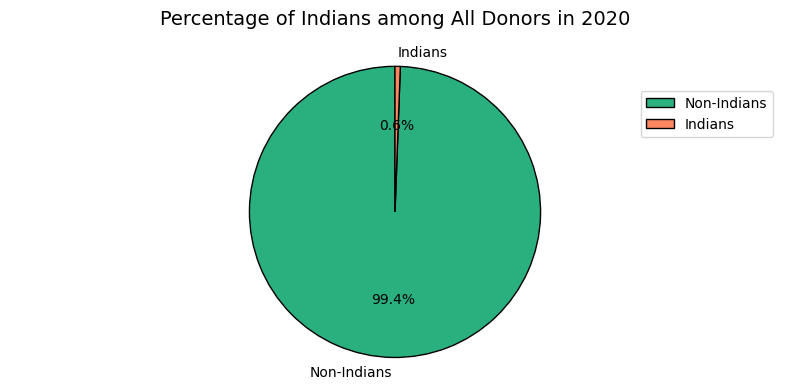

In [67]:
indian_counts = donors['ethnic'].value_counts()

plt.figure(figsize=(8, 4))
plt.pie(indian_counts, 
        labels=['Non-Indians', 'Indians'], 
        colors=['#2ab07f', '#fb8761'], 
        autopct='%1.1f%%', 
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        textprops={'fontsize': 10})

plt.title(f'Percentage of Indians among All Donors in 20{year}', pad=20, fontsize=14)
plt.axis('equal')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

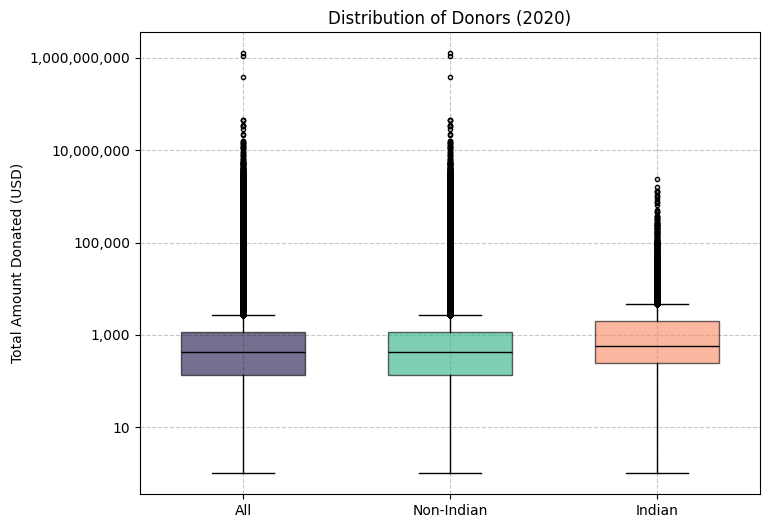

In [68]:
amounts_all = donors['total_donated']
amounts_non_indian = donors[donors['ethnic'] == "not"]['total_donated']
amounts_indian = donors[donors['ethnic'] == "ind"]['total_donated']

plt.figure(figsize=(8, 6))
plot = plt.boxplot([amounts_all, amounts_non_indian, amounts_indian], 
                   tick_labels=["All", "Non-Indian", "Indian"], 
                   patch_artist=True, 
                   widths=0.6, 
                   medianprops={"color": "black", "linewidth": 1}, 
                   flierprops={"marker": "o", "markersize": 3})

colors = ["#1b1044", "#2ab07f", "#fb8761"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title(f"Distribution of Donors (20{year})")
plt.ylabel("Total Amount Donated (USD)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

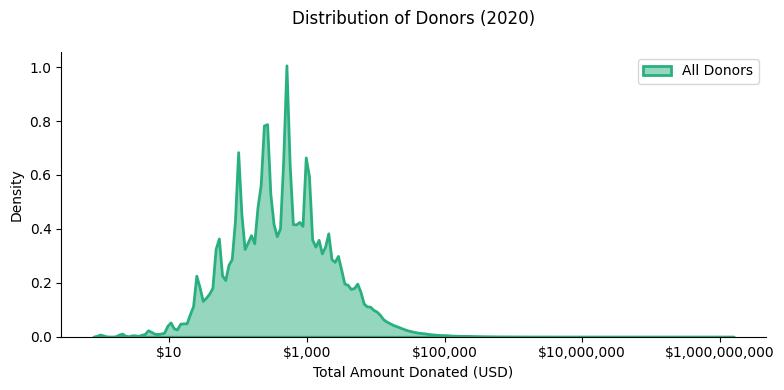

In [69]:
plt.figure(figsize=(8, 4))

sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
]['total_donated'],
            label='All Donors',
            color='#2ab07f',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)

plt.title(f"Distribution of Donors (20{year})", pad=20)
plt.xlabel("Total Amount Donated (USD)")
plt.ylabel("Density")
plt.xscale('log')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

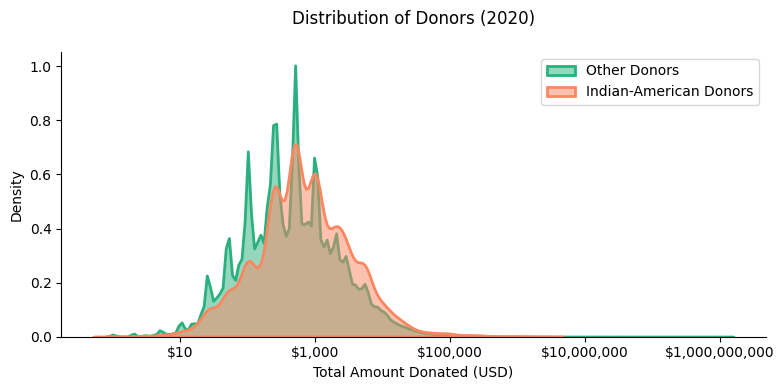

In [70]:
plt.figure(figsize=(8, 4))

sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
][donors['ethnic'] == "not"]['total_donated'],
            label='Other Donors',
            color='#2ab07f',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)
sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
][donors['ethnic'] == "ind"]['total_donated'],
            label='Indian-American Donors',
            color='#fb8761',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)

plt.title(f"Distribution of Donors (20{year})", pad=20)
plt.xlabel("Total Amount Donated (USD)")
plt.ylabel("Density")
plt.xscale('log')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

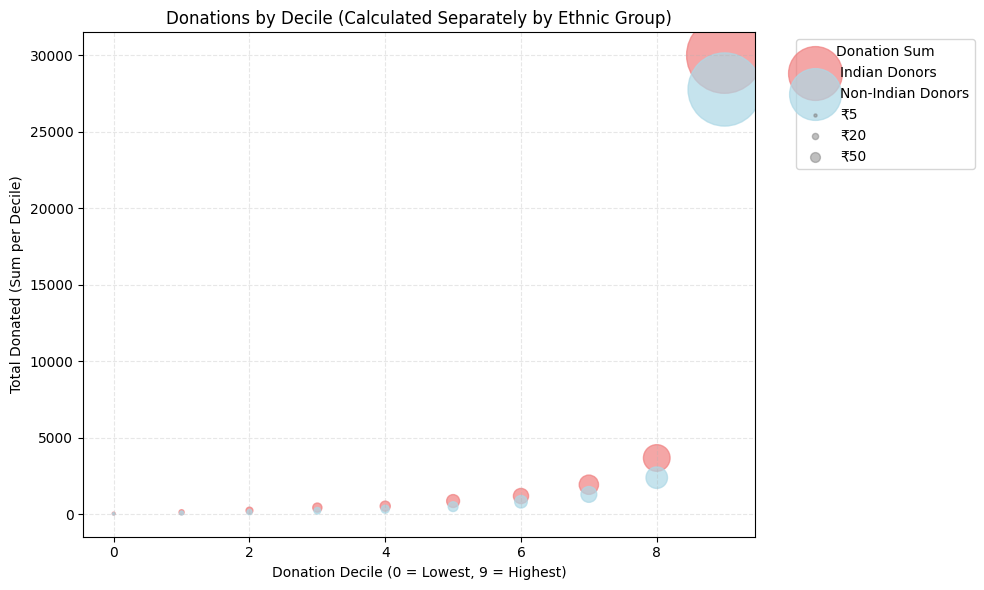

In [135]:
ind_donors = donors[donors['ethnic'] == 'ind'].copy()
not_donors = donors[donors['ethnic'] == 'not'].copy()

# --- STEP 2: Calculate deciles separately ---
def add_deciles(df):
    df['decile'] = pd.qcut(df['total_donated'], q=10, labels=False, duplicates='drop')
    return df

ind_donors = add_deciles(ind_donors)
not_donors = add_deciles(not_donors)

# --- STEP 3: Sum donations by decile for each group ---
ind_sum = ind_donors.groupby('decile')['total_donated'].mean().reset_index()
not_sum = not_donors.groupby('decile')['total_donated'].mean().reset_index()

# --- STEP 4: Plot ---
plt.figure(figsize=(10, 6))

# Indian donors (pastel red)
plt.scatter(
    x=ind_sum['decile'],
    y=ind_sum['total_donated'],
    s=ind_sum['total_donated'] / 10,  # Adjust scaling factor as needed
    c='lightcoral',
    alpha=0.7,
    label='Indian Donors'
)

# Non-Indian donors (pastel blue)
plt.scatter(
    x=not_sum['decile'],
    y=not_sum['total_donated'],
    s=not_sum['total_donated'] / 10,  # Same scaling factor
    c='lightblue',
    alpha=0.7,
    label='Non-Indian Donors'
)

# --- Customize plot ---
plt.xlabel('Donation Decile (0 = Lowest, 9 = Highest)')
plt.ylabel('Total Donated (Sum per Decile)')
plt.title('Donations by Decile (Calculated Separately by Ethnic Group)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

# Optional: Add legend for dot sizes (adjust values based on your data)
for amount in [5, 20, 50]:
    plt.scatter([], [], c='gray', alpha=0.5, s=amount, 
                label=f'₹{amount:,}')

plt.legend(title='Donation Sum', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [16]:
state_stats = (
    donors.groupby("state")
    .agg(
        avg_amount=("total_donated", "mean"),
        med_amount=("total_donated", "median"),
        total_donations=("total_donated", "sum"),
        donor_count=("total_donated", "count"),
        avg_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].mean()),
        med_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].median()),
        total_donations_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].sum()),
        donor_count_indian=("ethnic", lambda x: (x == "ind").sum())
    )
    .sort_values("total_donations", ascending=False)
    .reset_index()
)
state_stats.head(10)

,state,avg_amount,med_amount,total_donations,donor_count,avg_amount_indian,med_amount_indian,total_donations_indian,donor_count_indian
0,CA,6190.573397,471.0,3.367424e+09,543960,5422.377142,615.0,24053665.0,4436
1,NY,8464.925874,497.0,2.086477e+09,246485,4153.844391,575.0,8702304.0,2095
2,TX,2907.870775,500.0,7.675790e+08,263966,3293.483036,700.0,5727367.0,1739
3,FL,3149.138199,410.0,7.071264e+08,224546,7096.128927,628.0,6549727.0,923
4,IL,3051.937811,425.0,3.857802e+08,126405,3604.402394,687.5,3914381.0,1086
5,MA,3138.322948,500.0,3.450963e+08,109962,7248.609145,624.5,4914557.0,678
6,VA,2208.131878,500.0,2.599457e+08,117722,3979.825829,631.0,3358973.0,844
7,WA,2017.417650,390.0,2.502486e+08,124044,5054.495274,500.0,2673828.0,529
8,PA,1834.059197,401.0,2.457529e+08,133994,1650.469985,500.0,1127271.0,683
9,GA,2477.590946,500.0,2.429476e+08,98058,2154.245223,583.5,1352866.0,628


In [17]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
gdf_merged = gdf.merge(state_stats, on="state", how="left")

In [18]:
population = pd.read_csv("./data/aapi_population.csv", sep="\t")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2020,Alabama,AL,14673,5033094,0.291530
1,2020,Alaska,AK,0,733017,0.000000
2,2020,Arizona,AZ,62246,7187135,0.866075
3,2020,Arkansas,AR,12461,3014546,0.413362
4,2020,California,CA,856180,39521958,2.166340
5,2020,Colorado,CO,33486,5787129,0.578629
6,2020,Connecticut,CT,61888,3579918,1.728755
7,2020,Delaware,DE,16076,991928,1.620682
8,2020,District of Columbia,DC,176769,670917,26.347372
9,2020,Florida,FL,181805,21592035,0.842000


In [19]:
gdf_merged = gdf_merged.merge(population, left_on="state", right_on="Code", how="left")

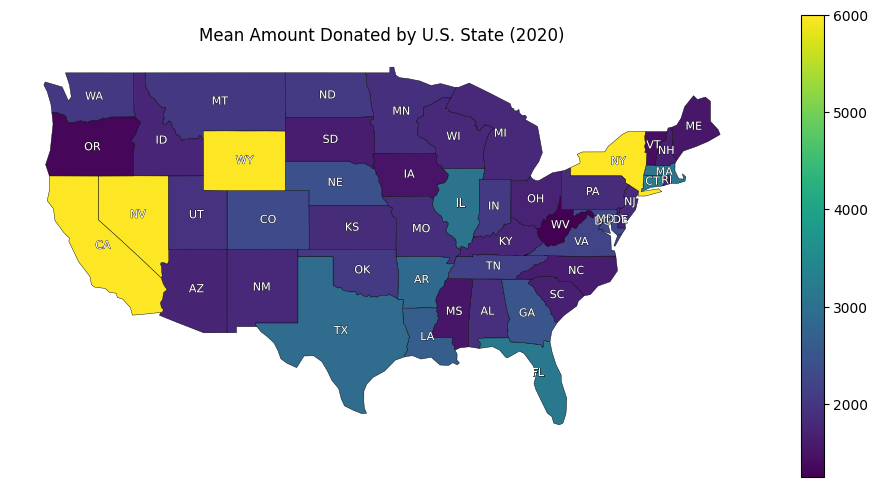

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=6000
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Mean Amount Donated by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

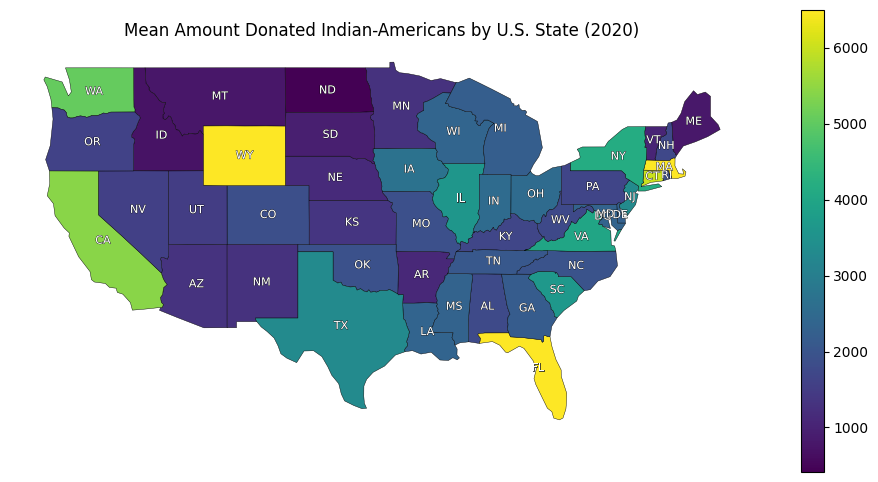

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount_indian",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=6500
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Mean Amount Donated Indian-Americans by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

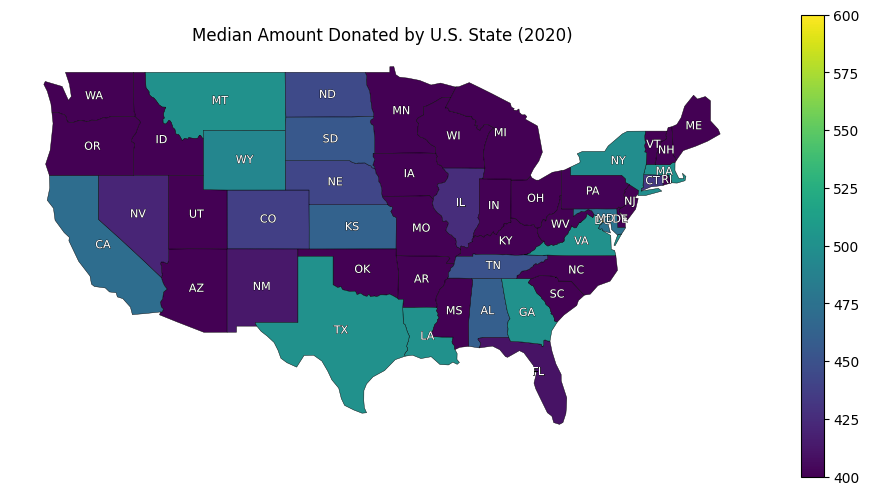

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=400,
    vmax=600
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Median Amount Donated by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

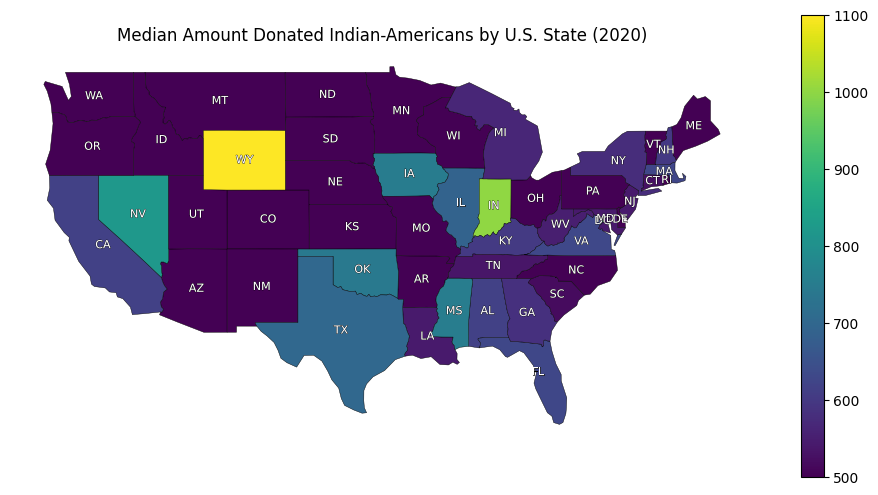

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount_indian",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=500,
    vmax=1100
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Median Amount Donated Indian-Americans by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

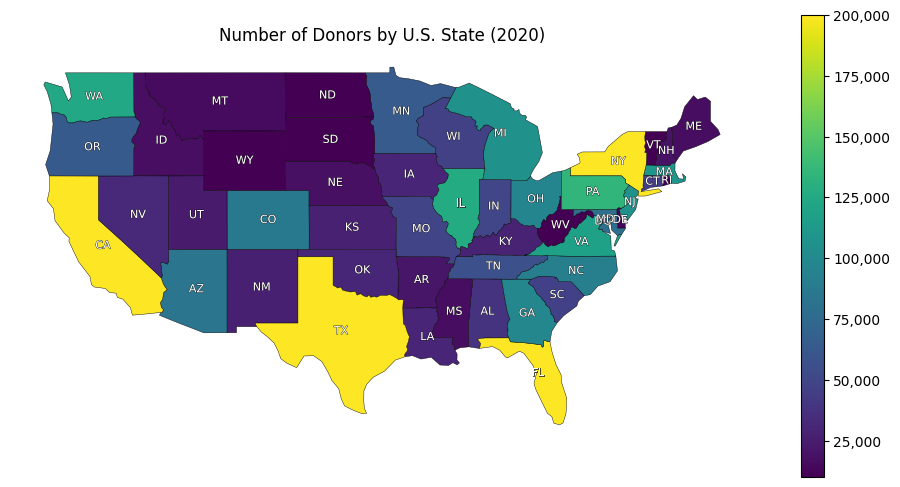

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="donor_count",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=10000,
    vmax=200000
)

cbar = fig.axes[-1]
cbar.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Number of Donors by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

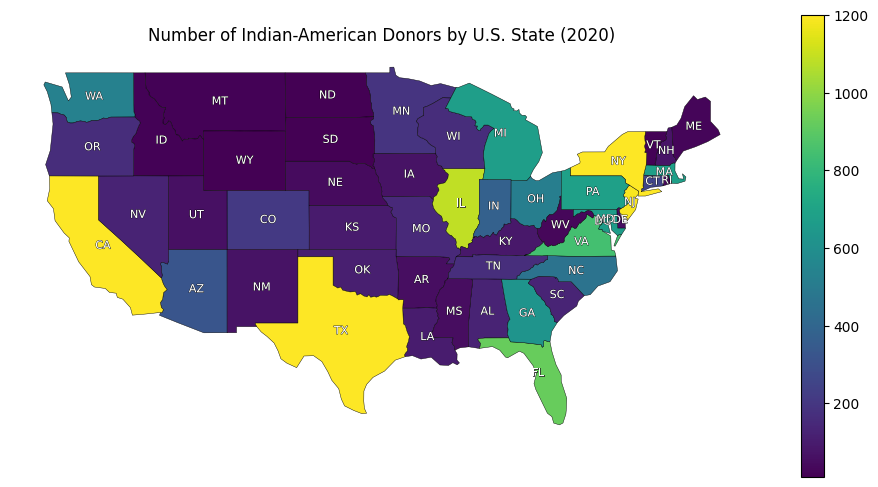

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="donor_count_indian",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=1200
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Number of Indian-American Donors by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [57]:
gdf_merged[["state", "donor_count_indian"]].sort_values(by="donor_count_indian", ascending=False).tail(15)

,state,donor_count_indian
9,NM,67
11,UT,58
41,DE,56
13,AR,53
30,MS,51
17,NE,46
25,RI,42
40,WV,32
47,ME,28
26,VT,19


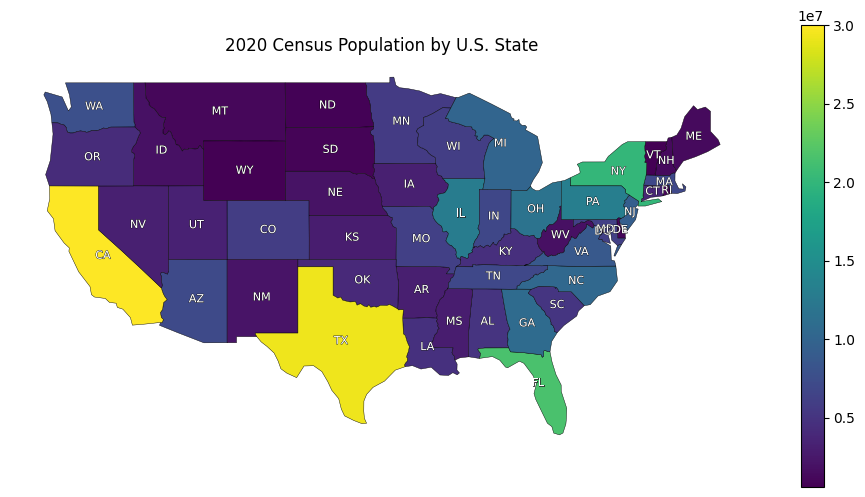

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="Census Pop",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=30000000,
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"2020 Census Population by U.S. State")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

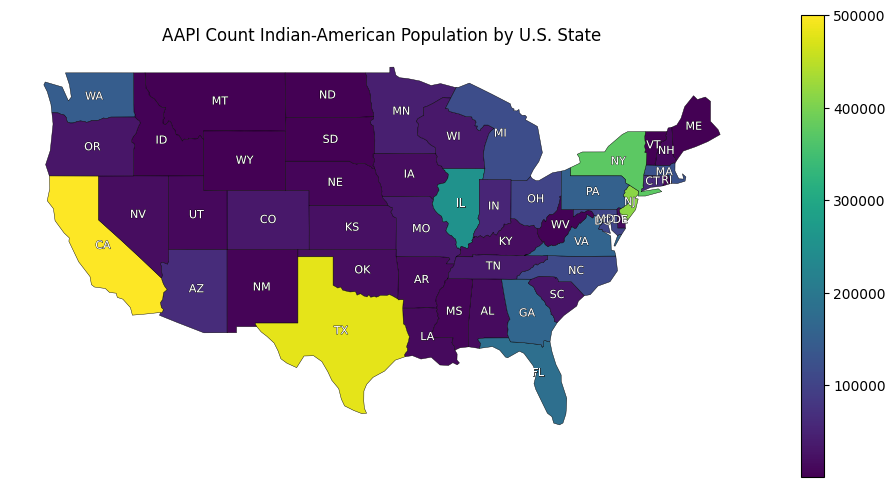

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="Indian Pop",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=500000
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"AAPI Count Indian-American Population by U.S. State")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [45]:
gdf_merged[["state", "Indian Pop"]].sort_values(by="Indian Pop", ascending=False).head(10)

,state,Indian Pop
6,CA,856180
21,TX,479704
44,NJ,413540
45,NY,374225
32,IL,253650
28,FL,181805
42,DC,176769
29,GA,162872
38,VA,159867
46,PA,153801


In [47]:
gdf_merged[gdf_merged["state"].isin(["CA", "TX", "NJ", "NY", "IL"])]["Indian Pop"].sum() / gdf_merged["Indian Pop"].sum() * 100

52.35908928227294

In [55]:
gdf_merged["donor_rate"] = gdf_merged["donor_count"] / gdf_merged["Census Pop"] * 100
gdf_merged[["donor_rate"]].mean()

donor_rate    1.144083
dtype: float64

In [54]:
gdf_merged["donor_rate_indian"] = gdf_merged["donor_count_indian"] / gdf_merged["Indian Pop"] * 100
gdf_merged[["donor_rate_indian"]].mean()

donor_rate_indian    0.647781
dtype: float64

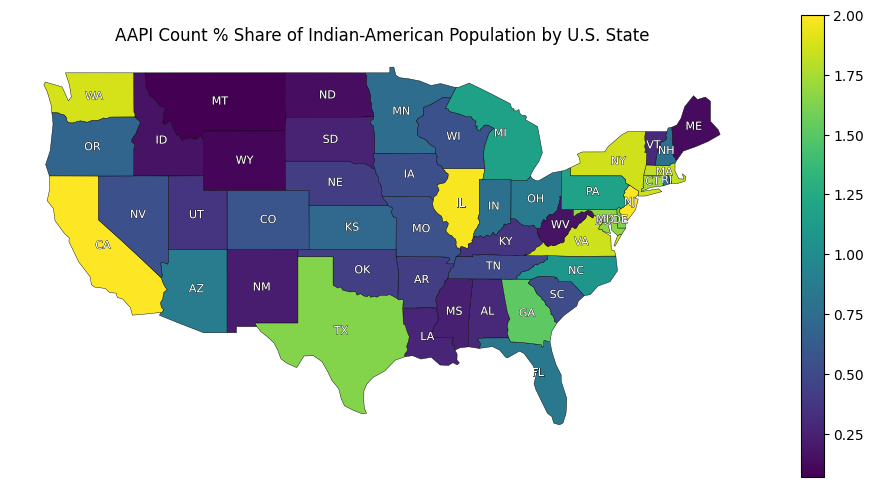

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="Share",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=2
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"AAPI Count % Share of Indian-American Population by U.S. State")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [43]:
gdf_merged[["state", "Share"]].sort_values(by="Share", ascending=False).head(10)

,state,Share
42,DC,26.347372
44,NJ,4.459713
6,CA,2.166340
32,IL,1.981782
4,WA,1.877806
45,NY,1.861337
38,VA,1.850823
23,MA,1.820476
22,CT,1.728755
43,MD,1.672064


In [31]:
gdf_merged["don_per_capita"] = gdf_merged["donor_count"] / gdf_merged["Census Pop"] * 100
gdf_merged["don_per_capita_indian"] = gdf_merged["donor_count_indian"] / gdf_merged["Indian Pop"] * 100
gdf_merged["don_per_capita_diff"] = gdf_merged["don_per_capita_indian"] - gdf_merged["don_per_capita"]
gdf_merged["dollars_per_capita"] = gdf_merged["total_donations"] / gdf_merged["Census Pop"]
gdf_merged["dollars_per_capita_indian"] = gdf_merged["total_donations_indian"] / gdf_merged["Indian Pop"]
gdf_merged["dollars_per_capita_diff"] = gdf_merged["dollars_per_capita_indian"] - gdf_merged["dollars_per_capita"]

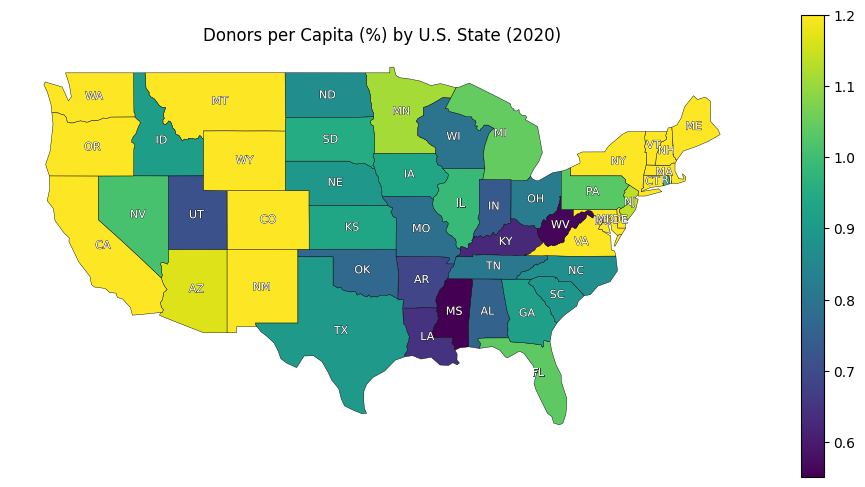

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="don_per_capita",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=1.2
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Donors per Capita (%) by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

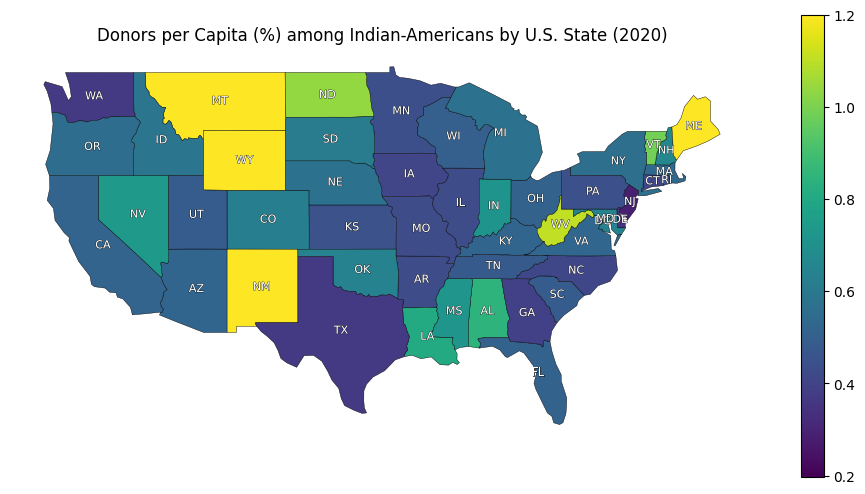

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="don_per_capita_indian",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=1.2
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Donors per Capita (%) among Indian-Americans by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

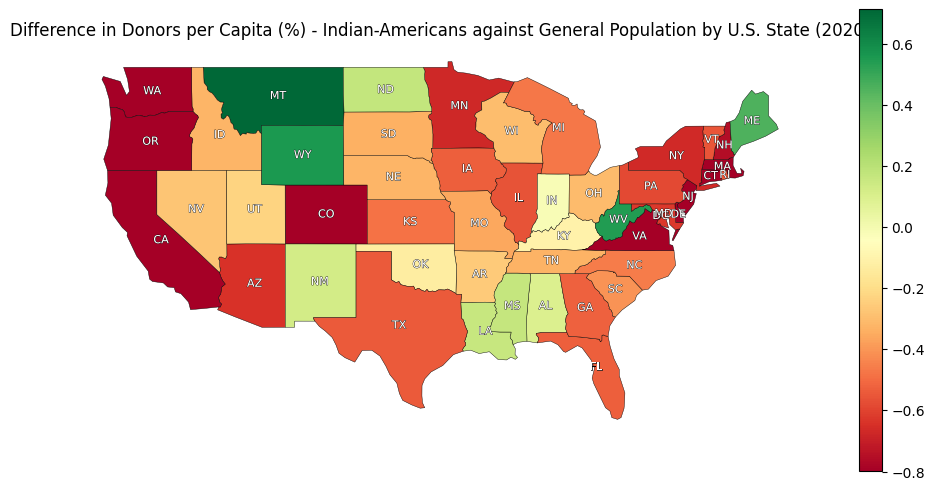

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="don_per_capita_diff",
    cmap="RdYlGn",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=-0.8
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Difference in Donors per Capita (%) - Indian-Americans against General Population by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

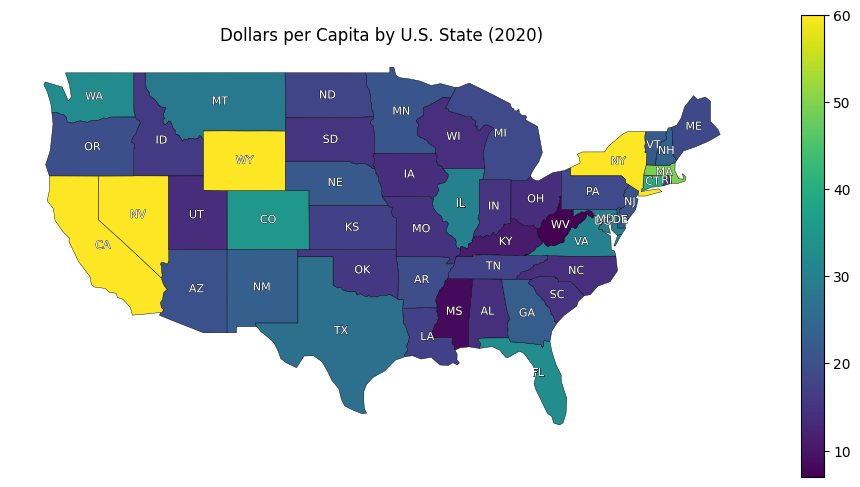

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="dollars_per_capita",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=60
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Dollars per Capita by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

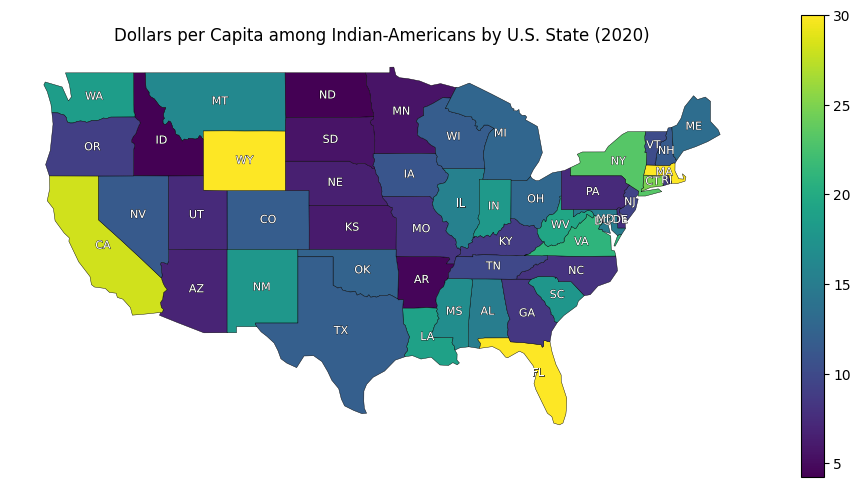

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="dollars_per_capita_indian",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=30
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Dollars per Capita among Indian-Americans by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

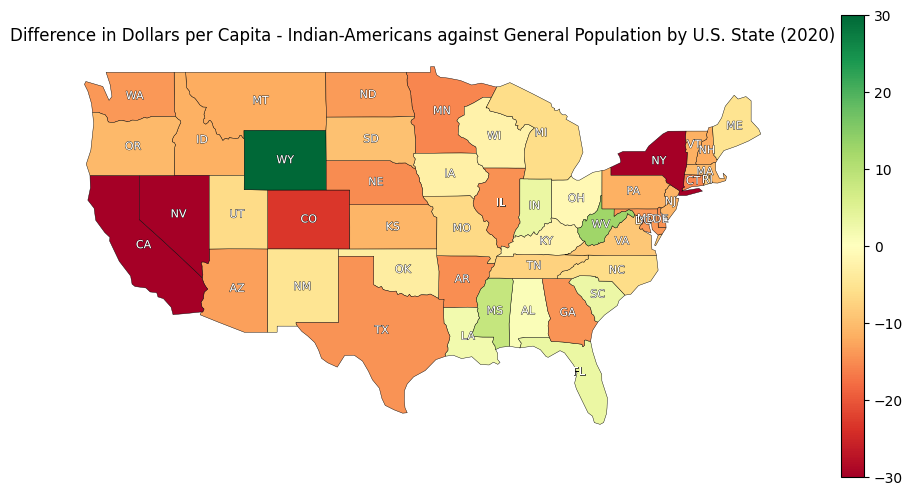

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="dollars_per_capita_diff",
    cmap="RdYlGn",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=-30,
    vmax=30
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Difference in Dollars per Capita - Indian-Americans against General Population by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [38]:
donors[(donors["contrib_id"] == donors.loc[0, "contrib_id"]) & (donors["occupation"].isna())]["total_donated"].sum() / donors["total_donated"].sum() * 100

10.506768716224439

In [39]:
pacs = donors[(donors["contrib_id"] == donors.loc[0, "contrib_id"]) & (donors["occupation"].isna())]

total_by_state = donors.groupby('state')['total_donated'].sum().rename('total_donated_all')
pacs_by_state = pacs.groupby('state')['total_donated'].sum().rename('total_donated_pacs')

result = pd.concat([total_by_state, pacs_by_state], axis=1)
result['pct_pac_dollars'] = (result['total_donated_pacs'] / result['total_donated_all']) * 100
result['pct_pac_dollars'] = result['pct_pac_dollars'].fillna(0)
result = result.reset_index()

result.sort_values(by='total_donated_pacs', ascending=False)

,state,total_donated_all,total_donated_pacs,pct_pac_dollars
13,CA,3.367424e+09,1.261253e+09,37.454541
0,,5.249103e+06,NaN,0.000000
1,99,1.299900e+04,NaN,0.000000
2,AA,9.116000e+03,NaN,0.000000
3,AB,1.129600e+04,NaN,0.000000
...,...,...,...,...
85,WI,8.316760e+07,NaN,0.000000
86,WV,1.248803e+07,NaN,0.000000
87,WY,7.219608e+07,NaN,0.000000
88,YT,1.583700e+04,NaN,0.000000


In [40]:
donors[(donors["contrib_id"].apply(lambda x: x[0]) == ' ')]

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,ACTBLUE,actblue actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,CA,1.261253e+09,25821,4.884603e+04,1000.0,actblue,not
18,,"NEA ADVOCACY FUND, ASSOCIATION",association nea advocacy fund,National Education Assn,NaN,L1300,,NOT APPLICABLE,NEA,WASHINGTON,DC,1.425899e+07,11,1.296272e+06,2800.0,nea advocacy fund,not
